# RAFT IVF-PQ tutorial
In this tutorial you will learn to build IVF-PQ index and use it to search approximate nearest neighbors (ANN).

In [44]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# We'll need to load store some data in this tutorial
import os
import tempfile

WORK_FOLDER = os.path.join(tempfile.gettempdir(), 'raft_ivf_pq_tutorial')

if not os.path.exists(WORK_FOLDER):
   os.makedirs(WORK_FOLDER)
print("The index and data will be saved in", WORK_FOLDER)

The index and data will be saved in /tmp/raft_ivf_pq_tutorial


## Get the data
We're going to use the data from [ANN benchmarks website](https://ann-benchmarks.com),
which provides a few datasets in [HDF5 format](https://www.hdfgroup.org/solutions/hdf5/).

The list of prepared dataset can be found at https://github.com/erikbern/ann-benchmarks/#data-sets

In [3]:
DATASET_URL = "http://ann-benchmarks.com/sift-128-euclidean.hdf5"
DATASET_FILENAME = DATASET_URL.split('/')[-1]

## download the dataset
import urllib.request
dataset_path = os.path.join(WORK_FOLDER, DATASET_FILENAME)
if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(DATASET_URL, dataset_path)

## Load the dataset

In [4]:
import h5py
f = h5py.File(dataset_path, "r")

metric = f.attrs['distance']

dataset = cp.array(f['train'])
queries = cp.array(f['test'])
gt_neighbors = cp.array(f['neighbors'])
gt_distances = cp.array(f['distances'])

print(f"Loaded dataset of size {dataset.shape}; metric: '{metric}'.")
print(f"Number of test queries: {queries.shape[0]}")

Loaded dataset of size (1000000, 128); metric: 'euclidean'.
Number of test queries: 10000


## Build the index
Construction of the index generally consists of two phases: training (building the clusters) and filling-in (extending the index with data).
In the first phase, a balanced hierarchical k-means algorithm clusters the training data.
In the second phase, the new data is classified and added into the appropriate clusters in the index.
Hence, a user should call `ivf_pq.build` once and then possibly `ivf_pq.extend` several times.
Though for user convenience `ivf_pq.build` by default adds the whole training set into the index.

In [5]:
# RAFT's DeviceResources controls the GPU, cuda stream, memory policies etc.
# For now, we just create a default instance.
from pylibraft.common import DeviceResources
resources = DeviceResources()

In [6]:
from pylibraft.neighbors import ivf_pq
# First, we need to initialize the build/indexing parameters.
# One of the more important parameters is the product quantisation (PQ) dim.
# Effectively, this parameter says
#      "shrink the dataset to this dimensionality to reduce the index size".
# It must be not bigger than the dataset dim,
# and it should be divisible by 32 for better GPU performance.
pq_dim = 1
while pq_dim * 2 < dataset.shape[1]:
    pq_dim = pq_dim * 2
# We'll use the ANN-benchmarks-provided metric and sensible defaults for the rest of parameters.
index_params = ivf_pq.IndexParams(n_lists=1024, metric=metric, pq_dim=pq_dim)

In [7]:
%%time
## Build the index
# This function takes a row-major either numpy or cupy (GPU) array.
# Generally, it's a bit faster with GPU inputs, but the CPU version may come in handy
# if the whole dataset cannot fit into GPU memory (or even CPU RAM -- use mmap for that).
index = ivf_pq.build(index_params, dataset, handle=resources)
# Sync the GPU to make sure we've got the timing right
resources.sync()
index

CPU times: user 4.48 s, sys: 1.06 s, total: 5.54 s
Wall time: 5.55 s


Index(type=IVF-PQ, metric=euclidean, codebook=subspace, size=1000000, dim=128, pq_dim=64, pq_bits=8, n_lists=1024, rot_dim=128)

## Search
The search function returns the requested number `k` of (approximate) nearest neighbor in no particular order.
Besides the queries and `k`, the function can take a few more parameters to tweak the performance of the algorithm.
Again, these are passed via the struct with some sensible defaults.

In [8]:
k = 10
search_params = ivf_pq.SearchParams()

In [9]:
%%time
distances, neighbors = ivf_pq.search(search_params, index, queries, k, handle=resources)
# Sync the GPU to make sure we've got the timing right
resources.sync()

CPU times: user 46.7 ms, sys: 2.84 ms, total: 49.6 ms
Wall time: 49.3 ms


In [10]:
## Check the quality of the prediction (recall)
def calc_recall(found_indicies, ground_truth):
    found_indicies = cp.asarray(found_indicies)
    bs, k = found_indicies.shape
    if bs != ground_truth.shape[0]:
        raise RuntimeError(
            "Batch sizes do not match {} vs {}".format(
                bs, ground_truth.shape[0])
        )
    if k > ground_truth.shape[1]:
        raise RuntimeError(
            "Not enough indicies in the ground truth ({} > {})".format(
                k, ground_truth.shape[1])
        )
    n = 0
    # Go over the batch
    for i in range(bs):
        # Note, ivf-pq does not guarantee the ordered input, hence the use of intersect1d
        n += cp.intersect1d(found_indicies[i, :k], ground_truth[i, :k]).size
    recall = n / found_indicies.size
    return recall

recall_first_try = calc_recall(neighbors, gt_neighbors)
print(f"Got recall = {recall_first_try} with the default parameters (k = {k}).")

Got recall = 0.85429 with the default parameters (k = 10).


## Refine
Let's improve our results a little bit!
The refinement operation follows an approximate NN search.
It recomputes the exact distances for the already selected candidates and selects a subset of them thus improving the recall.

In [11]:
from pylibraft.neighbors import refine

In [12]:
%%time

candidates = ivf_pq.search(search_params, index, queries, k * 2, handle=resources)[1]
distances, neighbors = refine(dataset, queries, candidates, k, handle=resources)
resources.sync()

CPU times: user 224 ms, sys: 12.1 ms, total: 236 ms
Wall time: 236 ms


In [13]:
recall_refine2x = calc_recall(neighbors, gt_neighbors)
print(f"Got recall = {recall_refine2x} with 2x refinement (k = {k}).")

Got recall = 0.95018 with 2x refinement (k = 10).


## Tweaking

#### Number of neighbors
Let see how QPS depens on `k`. 

38.6 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.5 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
42.2 ms ± 666 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
43.7 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
48 ms ± 3.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
44.7 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
54.2 ms ± 609 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
77.2 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
92.3 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
119 ms ± 852 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


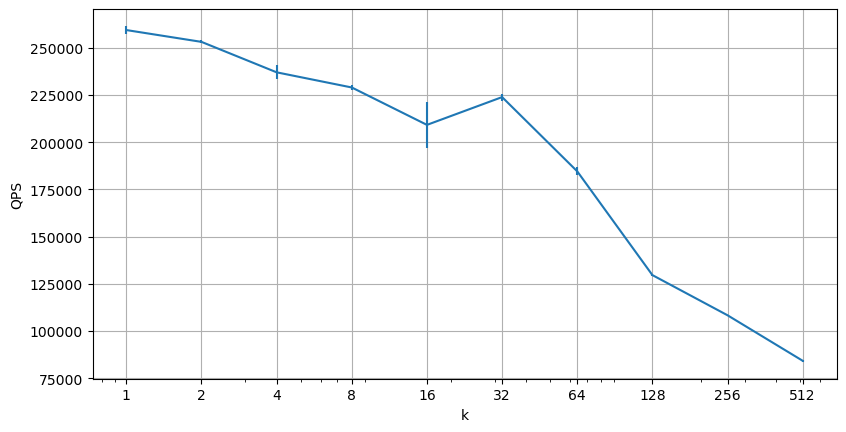

In [97]:
bench_k = np.exp2(np.arange(10)).astype(np.int32)
bench_avg = np.zeros_like(bench_k, dtype=np.float32)
bench_std = np.zeros_like(bench_k, dtype=np.float32)
for i, k in enumerate(bench_k):
    r = %timeit -o ivf_pq.search(search_params, index, queries, k, handle=resources); resources.sync()
    bench_avg[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
    bench_std[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).std()

fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
ax.errorbar(bench_k, bench_avg, bench_std)
ax.set_xscale('log')
ax.set_xticks(bench_k, bench_k)
ax.set_xlabel('k')
ax.grid()
ax.set_ylabel('QPS');

#### Number of probes
IVF-PQ search runs in two phases; first it looks for nearest clusters,
then it searches for the neighbors in every selected cluster.

We can set how many clusters we want to inspect.
For this, `ivf_pq.SearchParams` has a parameter `n_probes`.
This is the core parameter control the QPS/recall trade-off.

In [99]:
bench_probes = np.exp2(np.arange(11)).astype(np.int32)
bench_qps = np.zeros_like(bench_probes, dtype=np.float32)
bench_recall = np.zeros_like(bench_probes, dtype=np.float32)
k = 100
for i, n_probes in enumerate(bench_probes):
    sp = ivf_pq.SearchParams(n_probes=n_probes)
    r = %timeit -o ivf_pq.search(sp, index, queries, k, handle=resources); resources.sync()
    bench_qps[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
    bench_recall[i] = calc_recall(ivf_pq.search(sp, index, queries, k, handle=resources)[1], gt_neighbors)
    

9.16 ms ± 61.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.6 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
19.4 ms ± 393 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
30.2 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
47.8 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
109 ms ± 3.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
204 ms ± 917 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
389 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
751 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.4 s ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.72 s ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


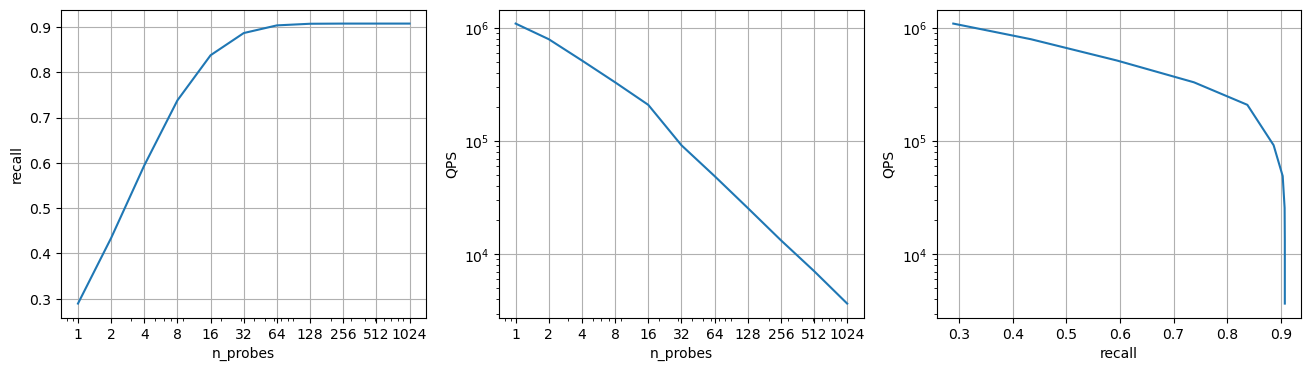

In [100]:
fig, ax = plt.subplots(1, 3, figsize=plt.figaspect(1/4))

ax[0].plot(bench_probes, bench_recall)
ax[0].set_xscale('log')
ax[0].set_xticks(bench_probes, bench_probes)
ax[0].set_xlabel('n_probes')
ax[0].set_ylabel('recall')
ax[0].grid()

ax[1].plot(bench_probes, bench_qps)
ax[1].set_xscale('log')
ax[1].set_xticks(bench_probes, bench_probes)
ax[1].set_xlabel('n_probes')
ax[1].set_ylabel('QPS')
ax[1].set_yscale('log')
ax[1].grid()

ax[2].plot(bench_recall, bench_qps)
ax[2].set_xlabel('recall')
ax[2].set_ylabel('QPS')
ax[2].set_yscale('log')
ax[2].grid();